In [12]:
from transformers import AutoModelForVision2Seq, AutoTokenizer, AutoProcessor
import numpy as np
from PIL import Image
import torch
import polars as pl
from PIL import Image
import io
import pickle
from tqdm.auto import tqdm
import lens
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [13]:
torch.set_grad_enabled(False)
device = None
if torch.cuda.is_available():
    device = 'cuda'
elif torch.mps.is_available():
    device = 'mps'
else: device = 'cpu'

In [14]:
# Загрузка модели и процессора
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-500M-Instruct")
model = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceTB/SmolVLM-500M-Instruct",
    torch_dtype=torch.bfloat16,
    #_attn_implementation="flash_attention_2" if device == "cuda" else "eager"
)

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


In [15]:
df = pl.read_parquet('/Users/hq-t77vj4f4r7/Documents/PersonalProjects/tlab_llm/sampled_data_250.parquet')

In [16]:
SAVE_PATH = 'test_save/'

100%|██████████| 250/250 [00:19<00:00, 12.92it/s]


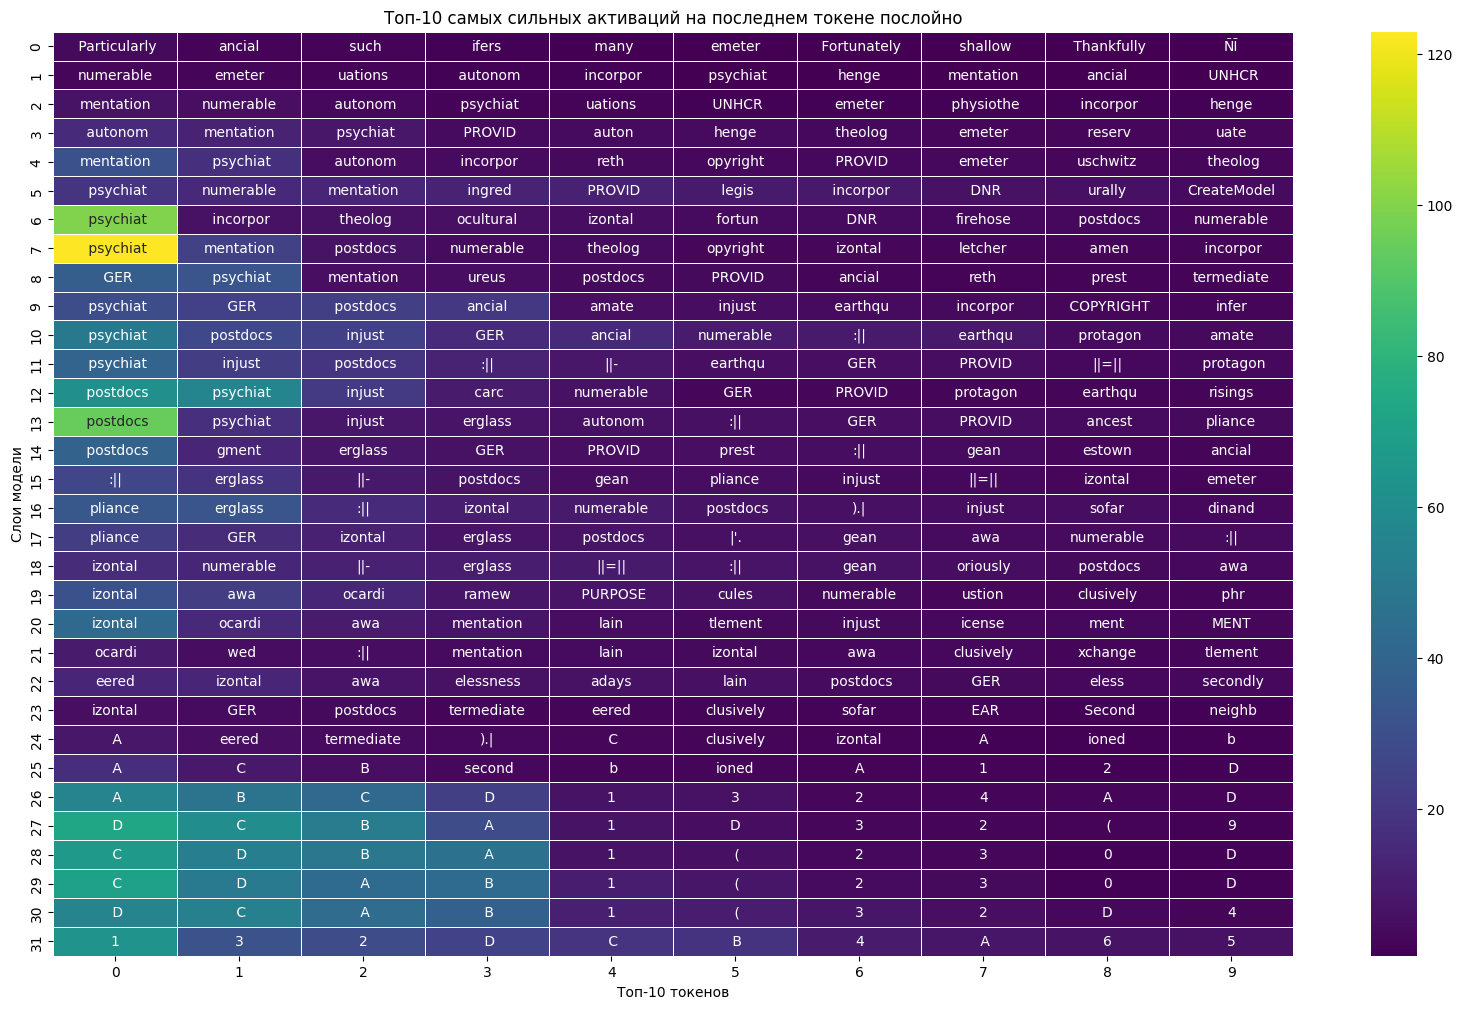

In [17]:
import seaborn as sns

data_matrix = None # (num_layers, vocabulary_size)
# data['text_lens']: (num_layers, 1, num_tokens, linear_len)

for i, question, answer, category, l2_category, image, meta_info in tqdm(df.iter_rows(), total=len(df)):
    data = np.load(SAVE_PATH + f'{i}_saved_dictionary.npz')
    text_activations = F.softmax(model.lm_head(model.model.text_model.norm(torch.tensor(data['text_lens'], dtype=torch.bfloat16))[:, 0, -1, :]), -1)
    
    if data_matrix is None:
        data_matrix = text_activations
    else:
        data_matrix += text_activations

# Подготовка данных для heatmap
heatmap_data = []
token_labels = []

for layer_idx, layer_probs in enumerate(data_matrix):
    top_ids = layer_probs.argsort(dim=-1, descending=True)[:10]  # Топ-10 активаций
    tokens = [processor.tokenizer.convert_ids_to_tokens(token_id.item()) for token_id in top_ids]
    
    heatmap_data.append(layer_probs[top_ids].cpu().float().numpy())
    token_labels.append([token.replace('Ġ', ' ') for token in tokens])

# Построение heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(heatmap_data, annot=token_labels, fmt="", cmap="viridis", linewidths=0.5)
plt.xlabel("Топ-10 токенов")
plt.ylabel("Слои модели")
plt.title("Топ-10 самых сильных активаций на последнем токене послойно")
plt.show()

100%|██████████| 250/250 [00:20<00:00, 12.49it/s]


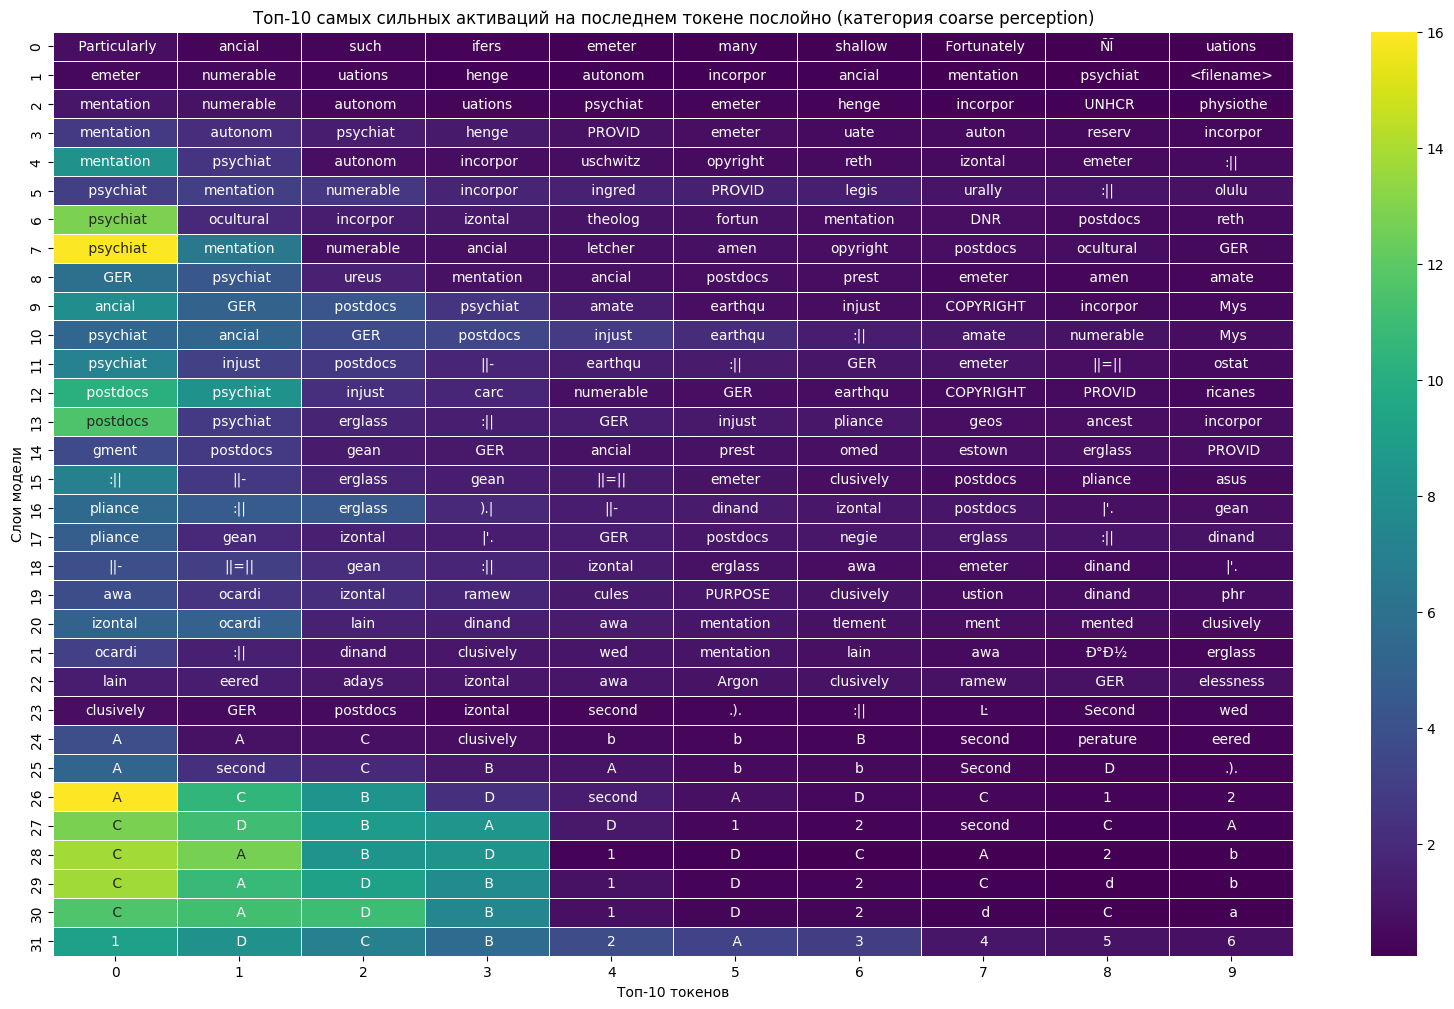

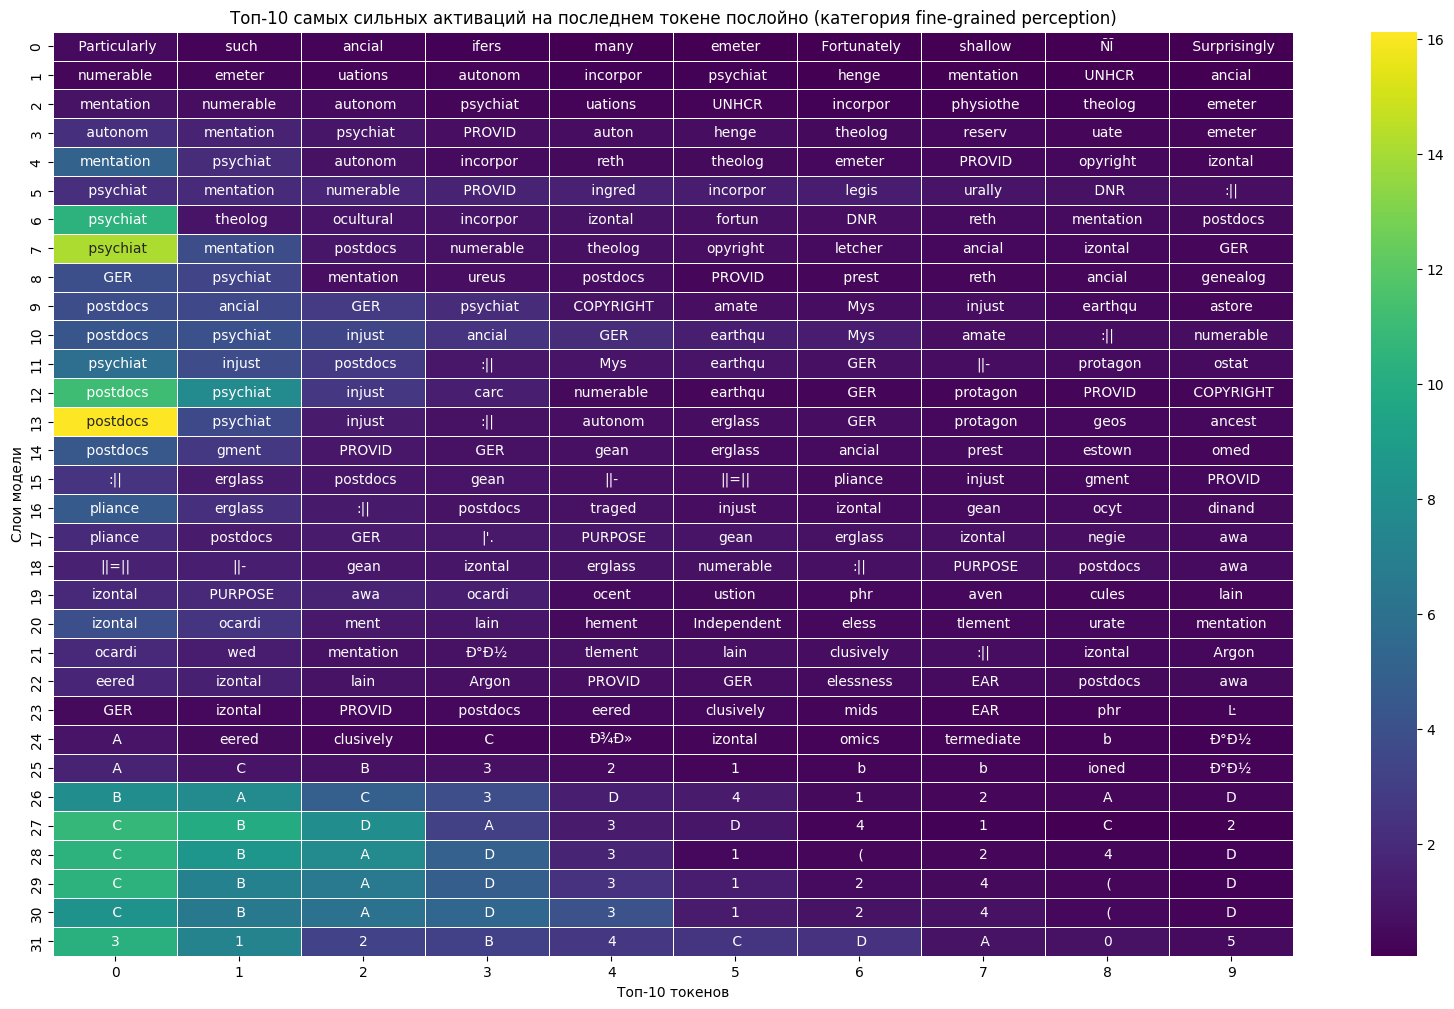

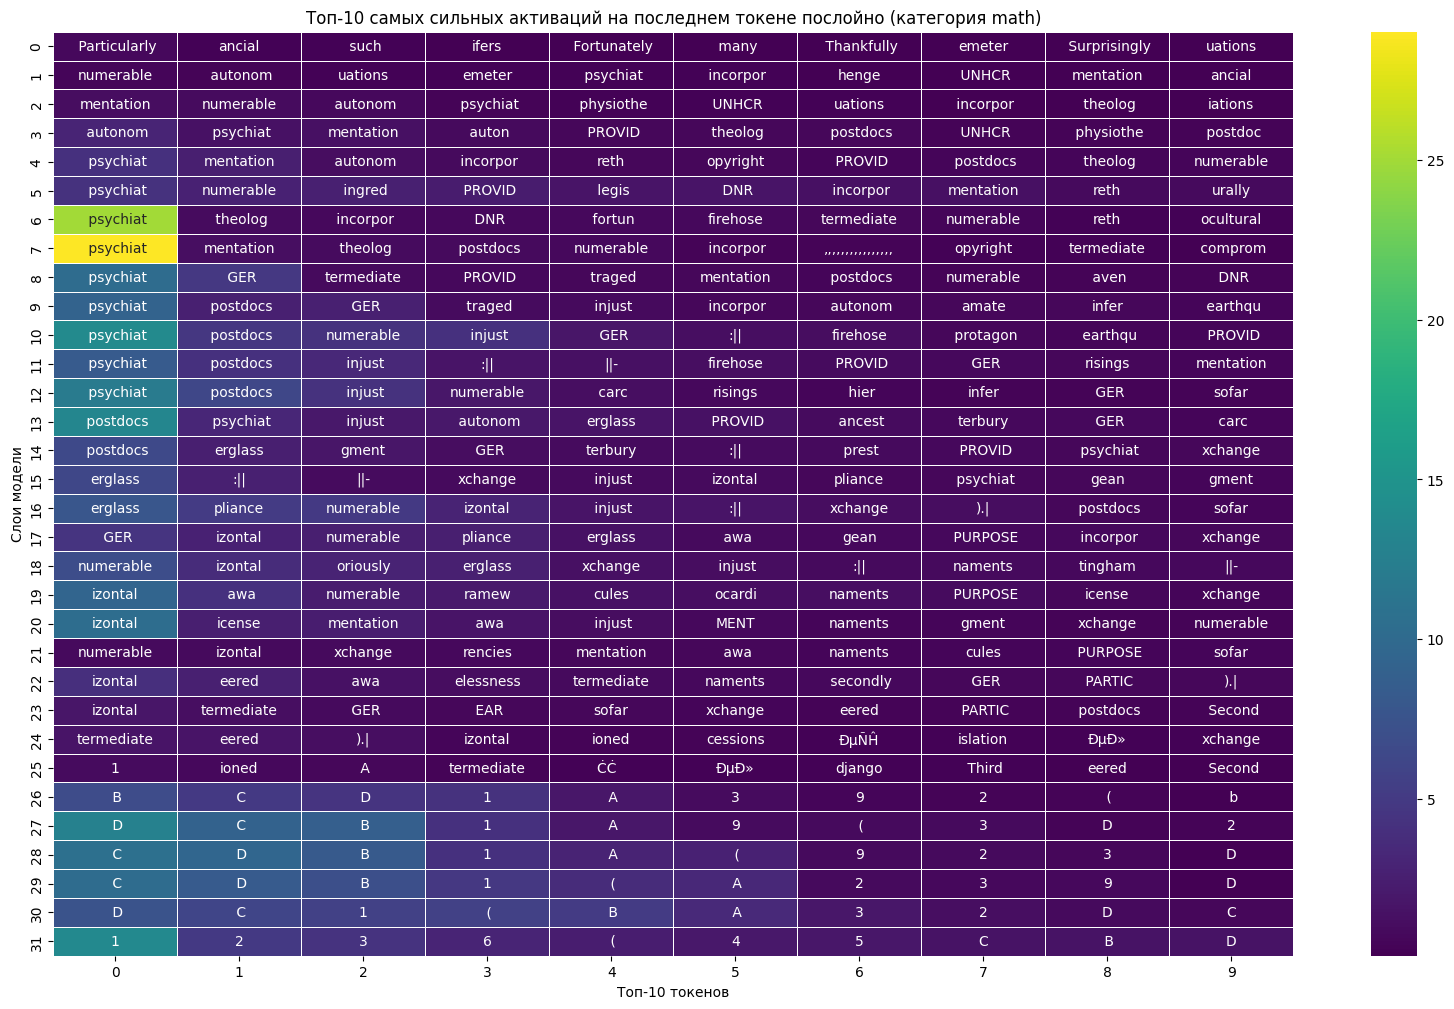

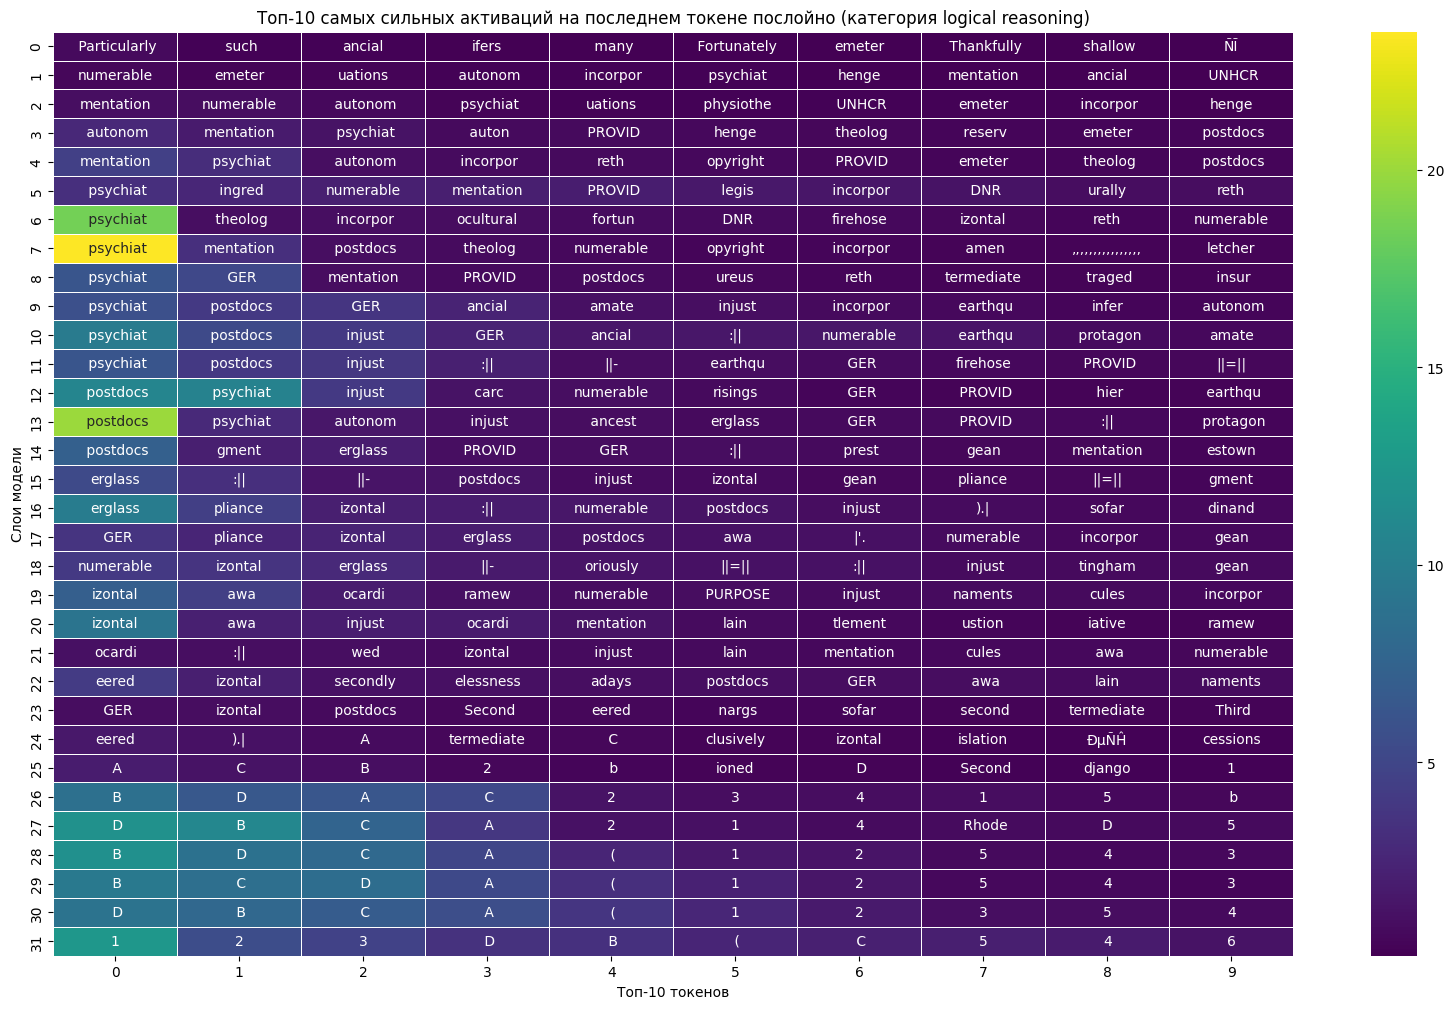

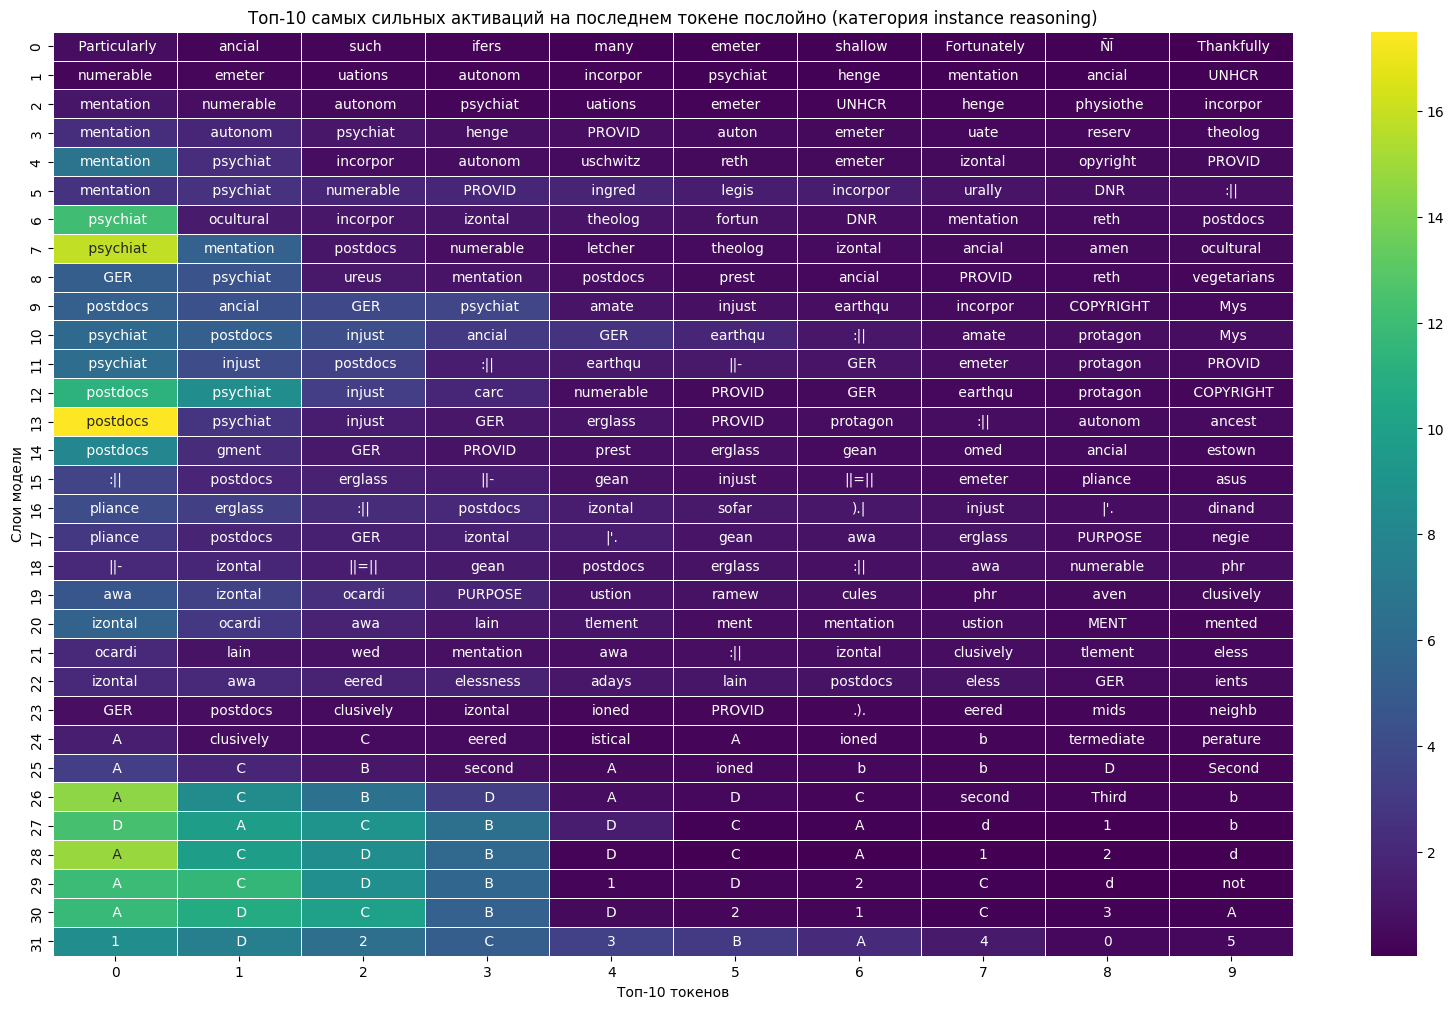

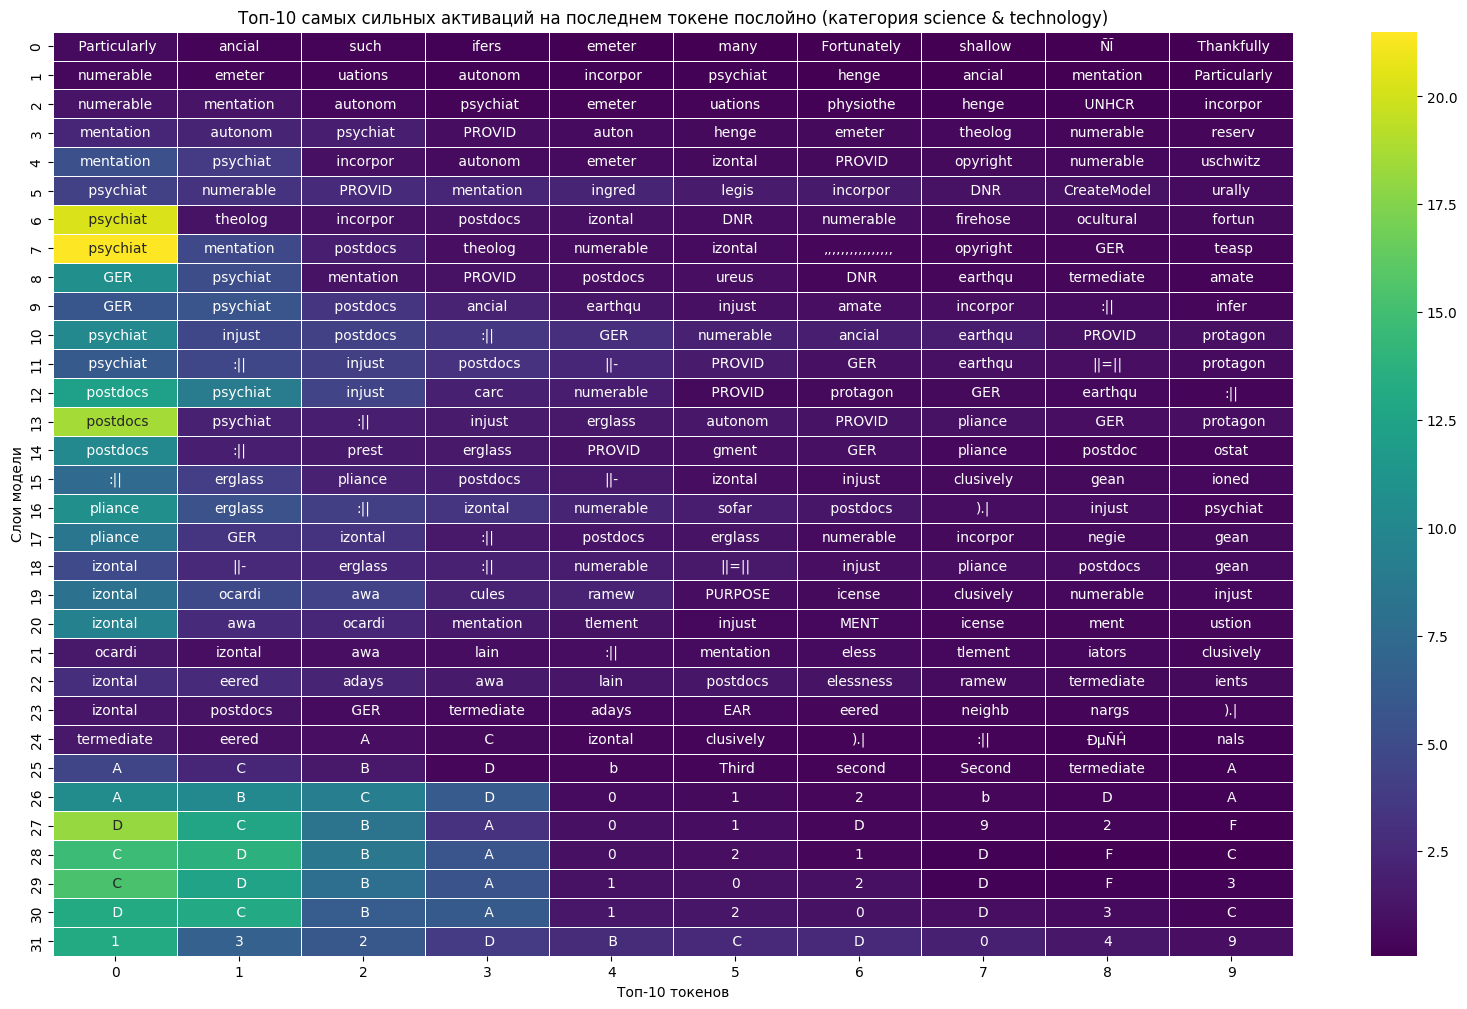

In [18]:
categorywise_data_matrix = {}  # {category: (num_layers, vocabulary_size)}

for i, question, answer, category, l2_category, image, meta_info in tqdm(df.iter_rows(), total=len(df)):
    data = np.load(SAVE_PATH + f'{i}_saved_dictionary.npz')
    text_activations = F.softmax(model.lm_head(model.model.text_model.norm(torch.tensor(data['text_lens'], dtype=torch.bfloat16))[:, 0, -1, :]), -1)
    
    if category not in categorywise_data_matrix:
        categorywise_data_matrix[category] = text_activations
    else:
        categorywise_data_matrix[category] += text_activations

# Подготовка данных для heatmap
heatmap_data = {}
token_labels = {}

for category, matrix in categorywise_data_matrix.items():
    heatmap_data[category] = []
    token_labels[category] = []
    
    for layer_probs in matrix:
        top_ids = layer_probs.argsort(dim=-1, descending=True)[:10]  # Топ-10 активаций
        tokens = [processor.tokenizer.convert_ids_to_tokens(token_id.item()) for token_id in top_ids]
        
        heatmap_data[category].append(layer_probs[top_ids].cpu().float().numpy())
        token_labels[category].append([token.replace('Ġ', ' ') for token in tokens])

for category in categorywise_data_matrix.keys():
    # Построение heatmap
    plt.figure(figsize=(20, 12))
    sns.heatmap(heatmap_data[category], annot=token_labels[category], fmt="", cmap="viridis", linewidths=0.5)
    plt.xlabel("Топ-10 токенов")
    plt.ylabel("Слои модели")
    plt.title(f"Топ-10 самых сильных активаций на последнем токене послойно (категория {category})")
    plt.show()

100%|██████████| 250/250 [56:42<00:00, 13.61s/it] 


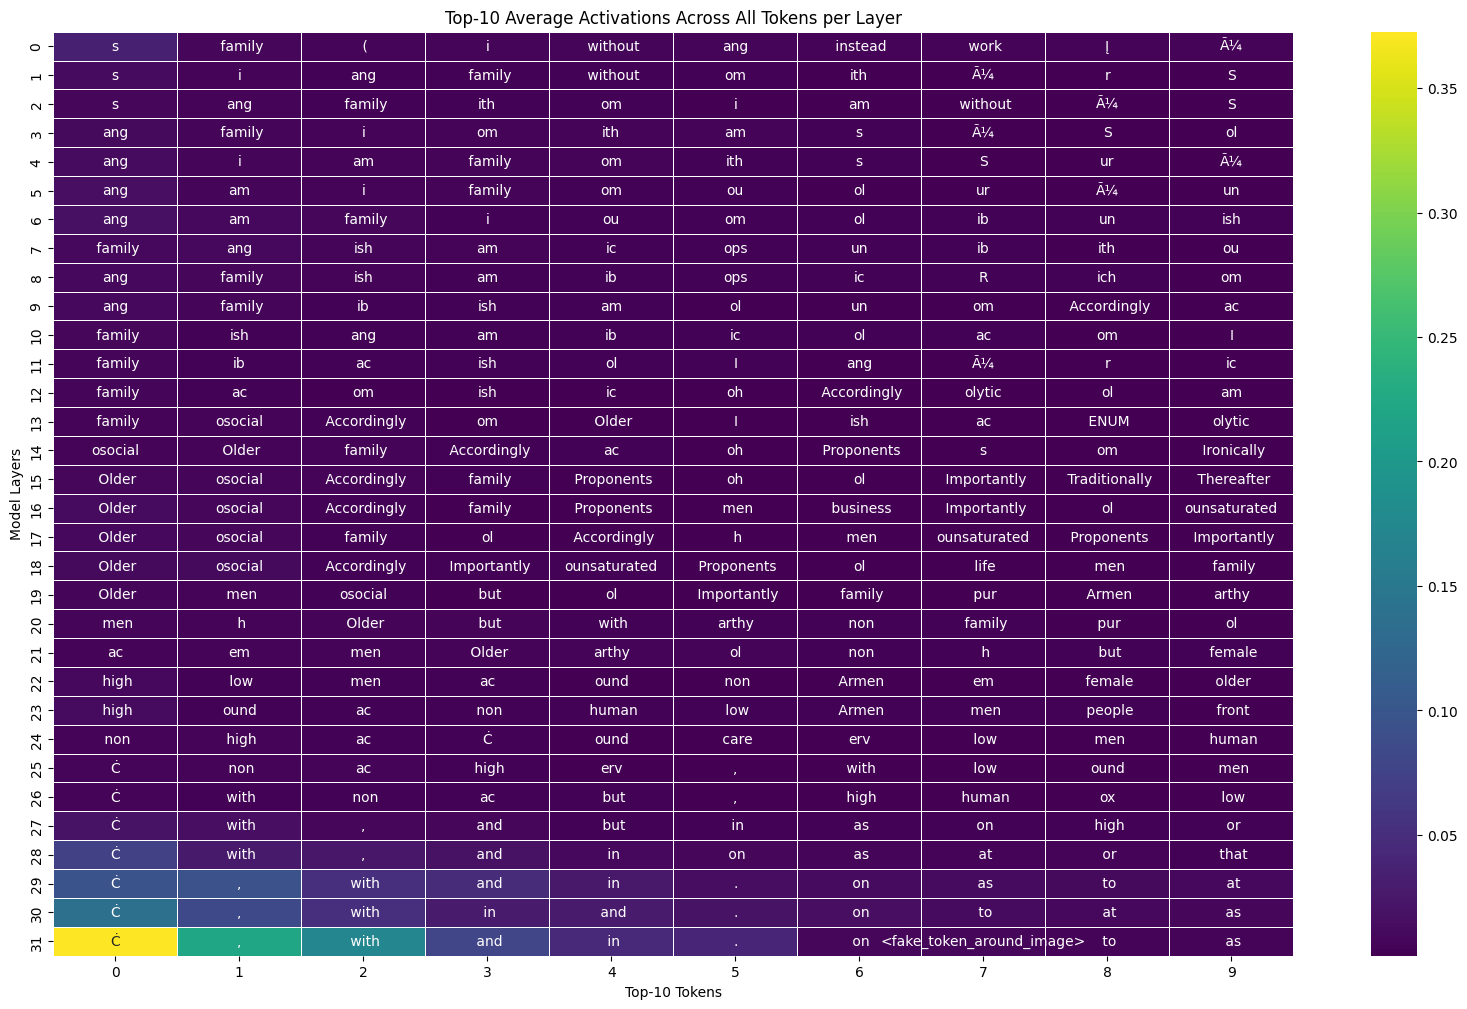

In [23]:
import seaborn as sns
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize with float32 for stable accumulation
data_matrix = None  # (num_layers, vocab_size)
total_tokens = 0
vocab_size = model.config.vocab_size
num_layers = 32

# Initialize once with zeros to prevent re-allocation
data_matrix = torch.zeros((num_layers, vocab_size), dtype=torch.float32)

for i, *_, meta_info in tqdm(df.iter_rows(), total=len(df)):
    data = np.load(SAVE_PATH + f'{i}_saved_dictionary.npz')
    text_lens = torch.tensor(data['text_lens'], dtype=torch.bfloat16)
    
    # Process one token at a time
    num_tokens = text_lens.shape[2]
    total_tokens += num_tokens
    
    # Process through model components sequentially
    with torch.no_grad():
        norm_output = model.model.text_model.norm(text_lens).squeeze(1)  # (num_layers, num_tokens, hidden_size)
        
        for token_idx in range(num_tokens):
            # Process single token across all layers
            hidden_states = norm_output[:, token_idx, :]  # (num_layers, hidden_size)
            logits = model.lm_head(hidden_states)  # (num_layers, vocab_size)
            
            # Directly accumulate logits (memory efficient)
            data_matrix += logits.float().to('cpu')

# Use log-softmax for final probabilities (numerically stable)
data_matrix = F.log_softmax(data_matrix / total_tokens, dim=-1)

# Prepare heatmap data
heatmap_data = []
token_labels = []

for layer_idx in range(num_layers):
    layer_logits = data_matrix[layer_idx]
    top_values, top_indices = torch.topk(layer_logits, 10)
    
    tokens = [processor.tokenizer.convert_ids_to_tokens(idx.item()) 
              for idx in top_indices]
    
    heatmap_data.append(top_values.exp().cpu().numpy())  # Convert back to probabilities
    token_labels.append([t.replace('Ġ', ' ') for t in tokens])

# Plotting remains the same
plt.figure(figsize=(20, 12))
sns.heatmap(heatmap_data, annot=token_labels, fmt="", cmap="viridis", linewidths=0.5)
plt.xlabel("Top-10 Tokens")
plt.ylabel("Model Layers")
plt.title("Top-10 Average Activations Across All Tokens per Layer")
plt.show()